In [6]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import xgboost as xgb
import time
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


random_state = 42
np.random.seed(random_state)



In [19]:
# Print all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# Load part of the train data
ctr15 = pd.read_csv("ctr_15.csv")
ctr16 = pd.read_csv("ctr_16.csv")
ctr17 = pd.read_csv("ctr_17.csv")
ctr18 = pd.read_csv("ctr_18.csv")
ctr19 = pd.read_csv("ctr_19.csv")
ctr20 = pd.read_csv("ctr_20.csv")
ctr21 = pd.read_csv("ctr_21.csv")
train_data = pd.concat([ctr15,ctr16,ctr17,ctr18,ctr19,ctr20,ctr21], ignore_index=True)

# Load the test data
test_data = pd.read_csv("ctr_test.csv")


In [20]:
# Train a tree on the train data
train_data = train_data.sample(frac=1/7, random_state=1234)
y = train_data["Label"]
x = train_data.drop(columns=["Label"])
x = x.select_dtypes(include='number')
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=3456)
del train_data
gc.collect()

1074

In [12]:
X_train.head()

,auction_age,auction_bidfloor,auction_time,creative_height,creative_width,timezone_offset
7831962,NaN,0.400000,1.516537e+09,NaN,NaN,1.0
4501541,38.0,0.070000,1.516405e+09,50.0,320.0,1.0
6902121,NaN,0.020000,1.516452e+09,50.0,320.0,1.0
4996404,NaN,0.061728,1.516364e+09,50.0,320.0,1.0
2475161,NaN,0.090000,1.516190e+09,250.0,300.0,1.0


In [21]:
print(len(X_train))
print(len(X_val))

864459
370483


In [8]:
# X_train = pd.get_dummies(X_train,
#                         columns = ['action_categorical_0', 'action_categorical_1', 'action_categorical_2', 'action_categorical_3', 'action_categorical_4', 'action_categorical_5', 'action_categorical_6', 'action_categorical_7'],
#                         sparse = True,    # Devolver una matriz rala.
#                         dummy_na = False, # No agregar columna para NaNs.
#                         dtype = int       # XGBoost no trabaja con 'object'; necesitamos que sean numéricos.
#                        )
# X_train

In [22]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                            seed = random_state,
                            eval_metric = 'auc')


In [23]:
from scipy.stats import uniform
params = {'max_depth': list(range(1, 20)),
          'learning_rate': uniform(scale = 0.2),
          'gamma': uniform(scale = 2),
          'reg_lambda': uniform(scale = 5),        # Parámetro de regularización.
          'subsample': uniform(0.5, 0.5),          # Entre 0.5 y 1.
          'min_child_weight': uniform(scale = 5),
          'colsample_bytree': uniform(0.75, 0.25), # Entre 0.75 y 1.
          'n_estimators': list(range(1, 1000))
         }

In [25]:
start = time.time()
best_score = 0
best_estimator = None
iterations = 50
for g in ParameterSampler(params, n_iter = iterations, random_state = random_state):
    clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', seed = random_state, eval_metric = 'auc', **g)
    clf_xgb.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = False)

    y_pred = clf_xgb.predict_proba(X_val)[:, 1] # Obtenemos la probabilidad de una de las clases (cualquiera).
    auc_roc = roc_auc_score(y_val, y_pred)
    # Guardamos si es mejor.
    if auc_roc > best_score:
        print(f'Mejor valor de ROC-AUC encontrado: {auc_roc}')
        best_score = auc_roc
        best_grid = g
        best_estimator = clf_xgb

end = time.time()
print('ROC-AUC: %0.5f' % best_score)
print('Grilla:', best_grid)
print(f'Tiempo transcurrido: {str(end - start)} segundos')
print(f'Tiempo de entrenamiento por iteración: {str(round((end - start) / iterations, 2))} segundos')

Mejor valor de ROC-AUC encontrado: 0.8360580707050204
Mejor valor de ROC-AUC encontrado: 0.8374420533897584
ROC-AUC: 0.83744
Grilla: {'colsample_bytree': 0.880208565006456, 'gamma': 1.9223440486986982, 'learning_rate': 0.1689067697356303, 'max_depth': 13, 'min_child_weight': 1.3567451588694794, 'n_estimators': 53, 'reg_lambda': 2.9337558283192413, 'subsample': 0.982627653632069}
Tiempo transcurrido: 4116.627385854721 segundos
Tiempo de entrenamiento por iteración: 82.33 segundos


In [26]:
best_estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                   seed = random_state,
                                   eval_metric = 'auc',
                                   **best_grid)

best_estimator.fit(X_train, y_train, verbose = True,  eval_set = [(X_val, y_val)])

# roc_auc_score requiere un array 1D; da lo mismo qué dimensión le pasemos: 90 o 1.
y_pred = best_estimator.predict_proba(X_val)[:, 1]
auc_roc = roc_auc_score(y_val, y_pred)
print('AUC-ROC validación: %0.5f' % auc_roc)

[0]	validation_0-auc:0.81044
[1]	validation_0-auc:0.81201
[2]	validation_0-auc:0.81314
[3]	validation_0-auc:0.82466
[4]	validation_0-auc:0.82751
[5]	validation_0-auc:0.82785
[6]	validation_0-auc:0.82533
[7]	validation_0-auc:0.82627
[8]	validation_0-auc:0.82480
[9]	validation_0-auc:0.82777
[10]	validation_0-auc:0.82836
[11]	validation_0-auc:0.83021
[12]	validation_0-auc:0.83165
[13]	validation_0-auc:0.83270
[14]	validation_0-auc:0.83170
[15]	validation_0-auc:0.83020
[16]	validation_0-auc:0.82950
[17]	validation_0-auc:0.83141
[18]	validation_0-auc:0.83318
[19]	validation_0-auc:0.83224
[20]	validation_0-auc:0.83388
[21]	validation_0-auc:0.83324
[22]	validation_0-auc:0.83422
[23]	validation_0-auc:0.83382
[24]	validation_0-auc:0.83485
[25]	validation_0-auc:0.83534
[26]	validation_0-auc:0.83503
[27]	validation_0-auc:0.83556
[28]	validation_0-auc:0.83595
[29]	validation_0-auc:0.83653
[30]	validation_0-auc:0.83692
[31]	validation_0-auc:0.83700
[32]	validation_0-auc:0.83715
[33]	validation_0-au

In [34]:
x_test=ctr20.drop(columns=["Label"])
y_test = ctr20["Label"]
x_test = x_test.select_dtypes(include='number')
y_pred = best_estimator.predict_proba(x_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred)
print('AUC-ROC test: %0.5f' % auc_roc)

AUC-ROC test: 0.82668


In [27]:
# Predict on the evaluation set
eval_data = test_data.select_dtypes(include='number')
y_preds = best_estimator.predict_proba(eval_data.drop(columns=["id"]))[:, best_estimator.classes_ == 1].squeeze()


creative_height     0.107970
auction_bidfloor    0.087762
creative_width      0.057441
timezone_offset     0.024481
auction_time        0.019863
auction_age         0.005981
Name: Label, dtype: float64


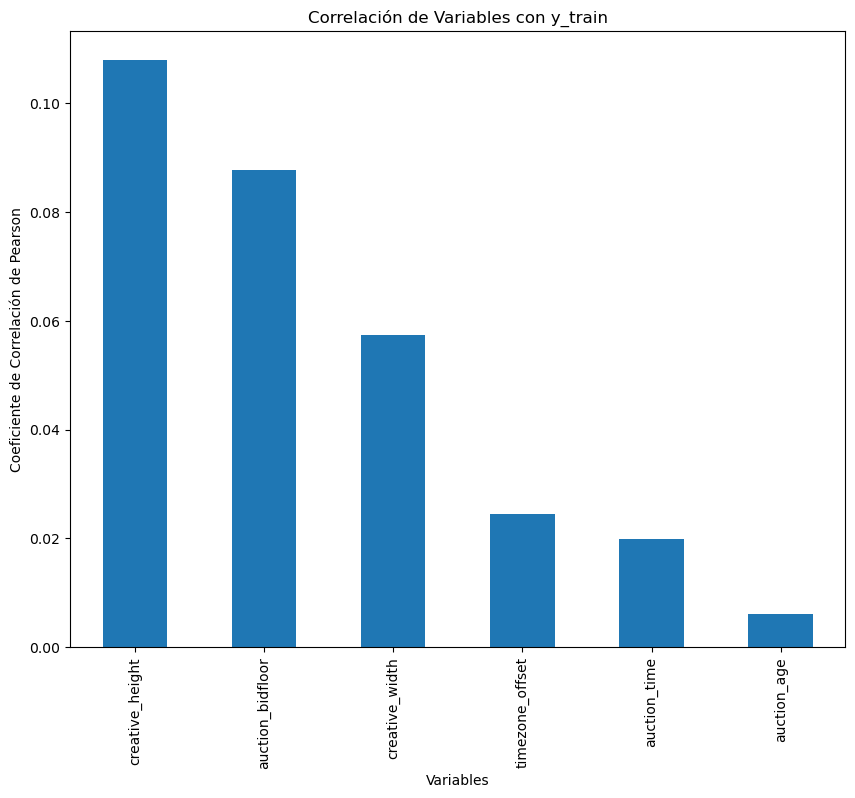

In [11]:
data_with_labels = pd.concat([X_train, y_train], axis=1)

# Calcular la correlación de Pearson entre las características y y_train
correlations = data_with_labels.corr()['Label'].drop('Label')  # Excluir la autocorrelación de 'Label'

# Ordenar las correlaciones de mayor a menor
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Imprimir las correlaciones
print(correlations_sorted)

# Graficar las correlaciones
plt.figure(figsize=(10, 8))
correlations_sorted.plot(kind='bar')
plt.title('Correlación de Variables con y_train')
plt.xlabel('Variables')
plt.ylabel('Coeficiente de Correlación de Pearson')
plt.show()

In [28]:
# Make the submission file
submission_df = pd.DataFrame({"id": eval_data["id"], "Label": y_preds})
submission_df["id"] = submission_df["id"].astype(int)
submission_df.to_csv("xgboost_model5.csv", sep=",", index=False)